In [16]:
import torch
import pandas as pd
import os

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Extraction of the files

In [17]:
metadata = pd.read_csv("images/metadata/images.csv")
metadata = metadata[(metadata["height"] >= 1000) & (metadata["width"] >= 1000)]

In [34]:
image_paths = metadata["path"].tolist()
len(image_paths)

342878

## `clip-ViT-B-32`
- `ViT` - Vision Transformer
- `B` - Base (not Large)
- `32` - image is cut into 32x32 patches

Length of output vector - 512

## SQLAlchemy

In [20]:
from sqlalchemy.engine import URL

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5556,
    database="similarity_search_service_db",
)

In [22]:
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from pgvector.sqlalchemy import Vector
from sqlalchemy import String
from typing import List


class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    __table_args__ = {"extend_existing": True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))

In [23]:
from sqlalchemy import create_engine

engine = create_engine(db_url)

In [24]:
# Create table
Base.metadata.create_all(engine)

## Image vectorization

In [26]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-B-32").to(device)

In [ ]:
import joblib
from PIL import Image
from sqlalchemy.orm import Session
from tqdm.notebook import tqdm
from itertools import batched

MAX_IMAGES = 30_000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def insert_images(engine, images):
    with Session(engine) as session:
        for img in images:
            session.add(img)
        session.commit()


def vectorize_images(engine, model, image_paths):
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(
            image_paths[:MAX_IMAGES], BATCH_SIZE
        ):  # finish (suggestion - use `batched`)
            images = [
                Image.open(os.path.join("images", "small", path))
                for path in images_paths_batch
            ]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            img_instances = [
                Img(image_path=path, embedding=emb)
                for path, emb in zip(images_paths_batch, embeddings)
            ]

            # insert all batch images
            insert_images(engine, img_instances)

            # update pbar
            pbar.update(len(images_paths_batch))


vectorize_images(engine, model, image_paths)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [55]:
import matplotlib.pyplot as plt
from sqlalchemy import select


class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images: List[Img] = self.find_similar_images(image_description, k)
        self.display_images(
            [img.image_path for img in found_images], k, title=image_description
        )

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = model.encode(image_description)

        # remember about session and commit
        query = (
            select(Img)
            .order_by(Img.embedding.cosine_distance(image_embedding))
            .limit(k)
            # write query to find K images with highest cosine distance
        )
        with Session(engine) as session:
            result = session.execute(query, execution_options={"prebuffer_rows": True})
        return result.scalars().all()

    def display_images(self, images, k, title=""):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))
        fig.suptitle(title)

        for i, img_path in enumerate(images):
            img = Image.open(os.path.join("images", "small", img_path))
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

### MAX_IMAGES = 100_000

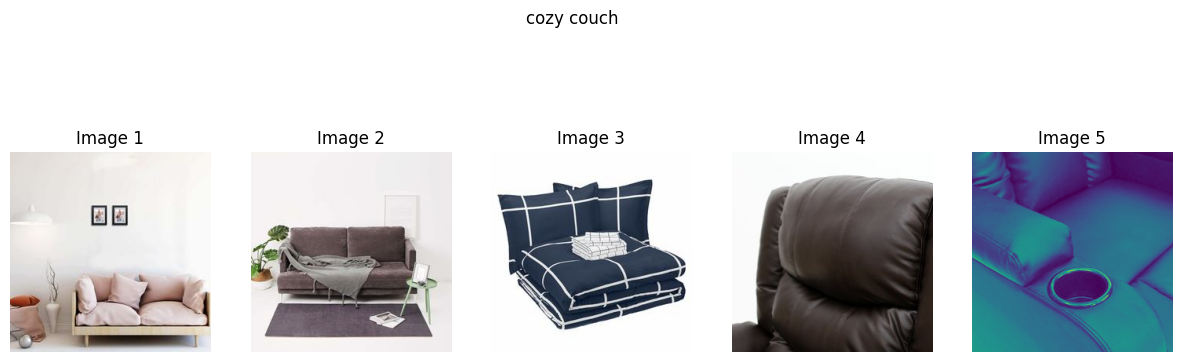

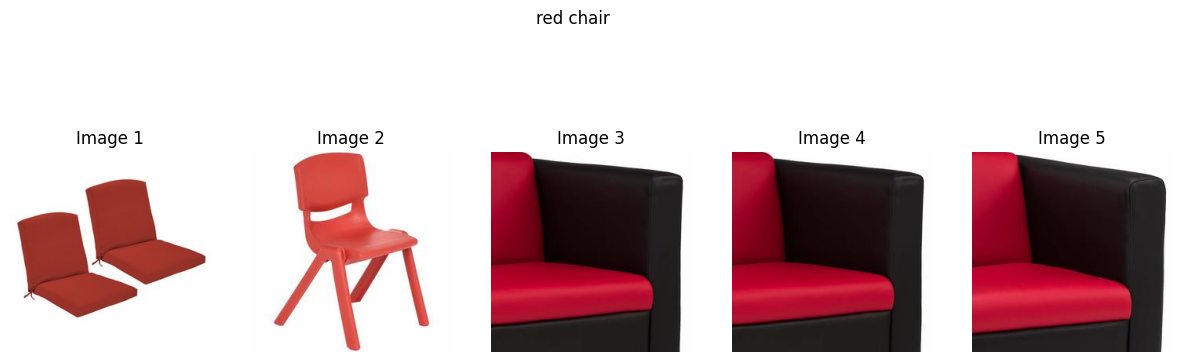

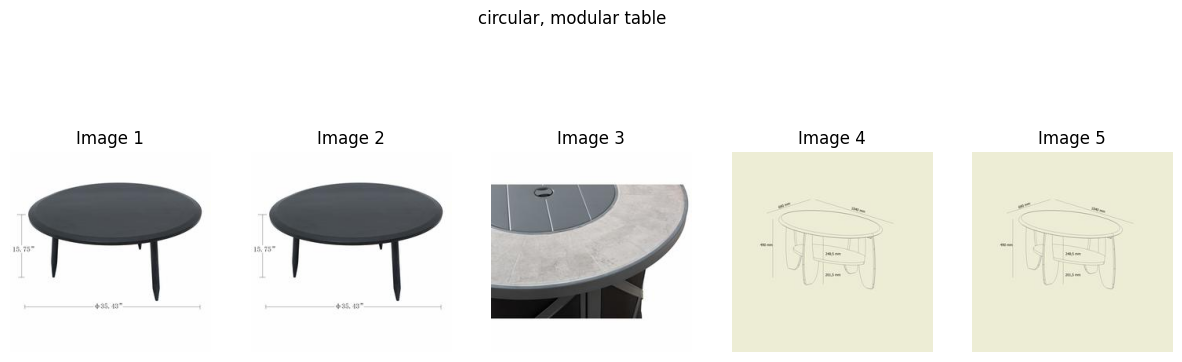

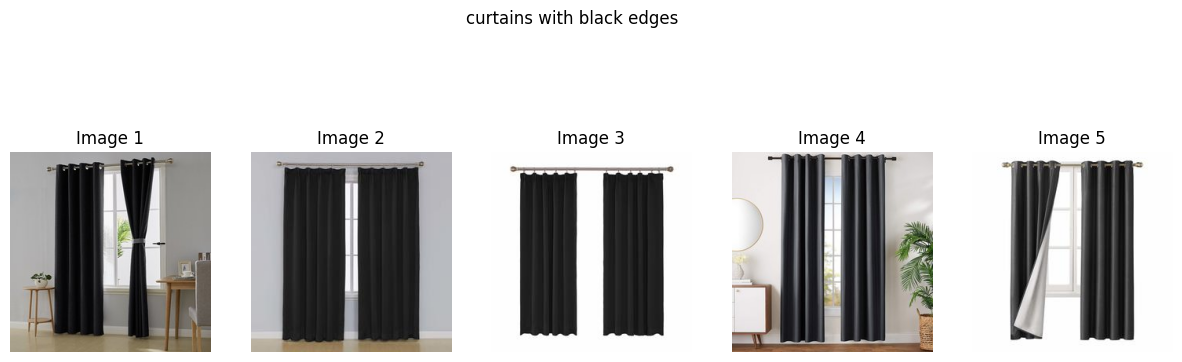

In [62]:
image_search = ImageSearch(engine, model)
image_search("cozy couch", 5)
image_search("red chair", 5)
image_search("circular, modular table", 5)
image_search("curtains with black edges", 5)

The results look pretty good, most of them got at least one image right, and all pictures are kind of inline with the querry.

### MAX_IMAGES = 200_000

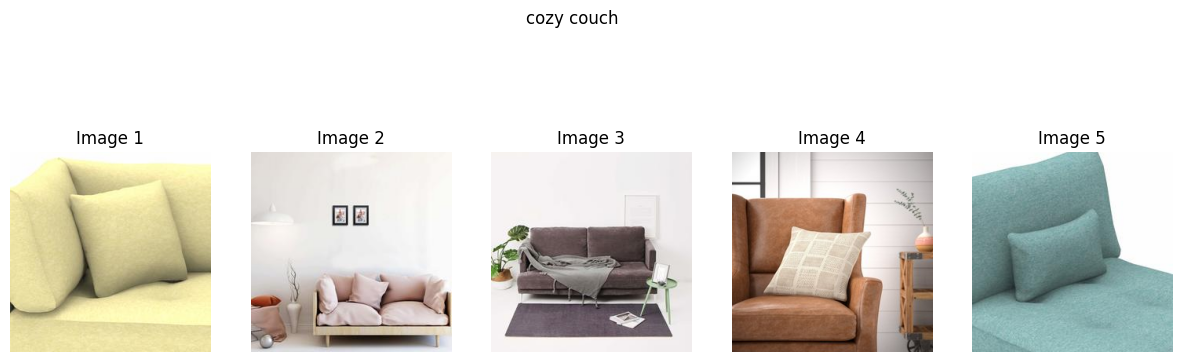

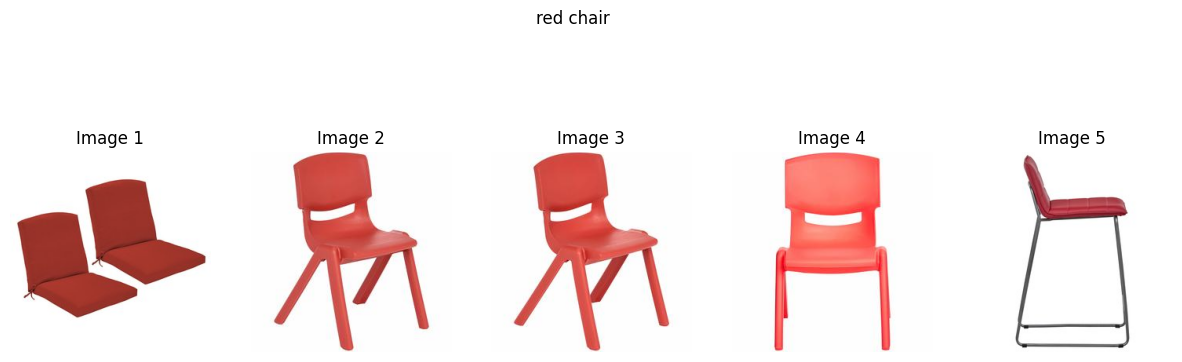

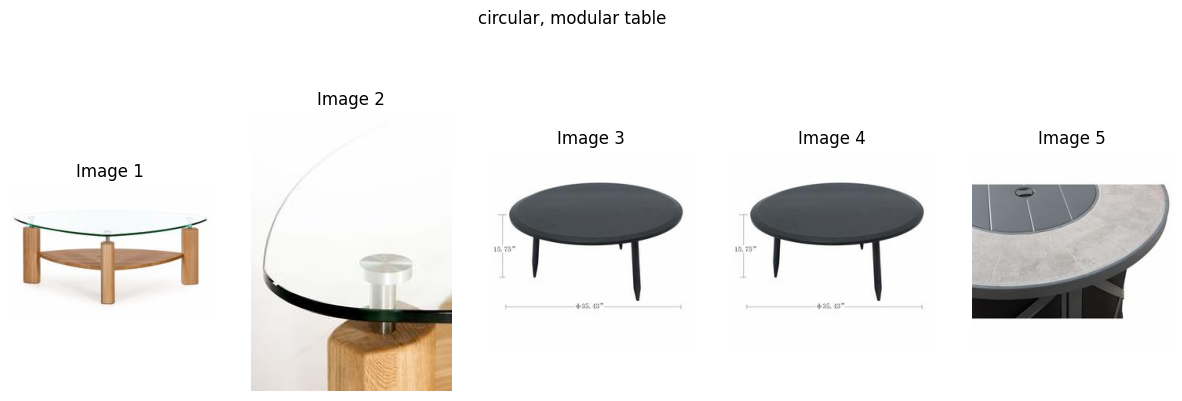

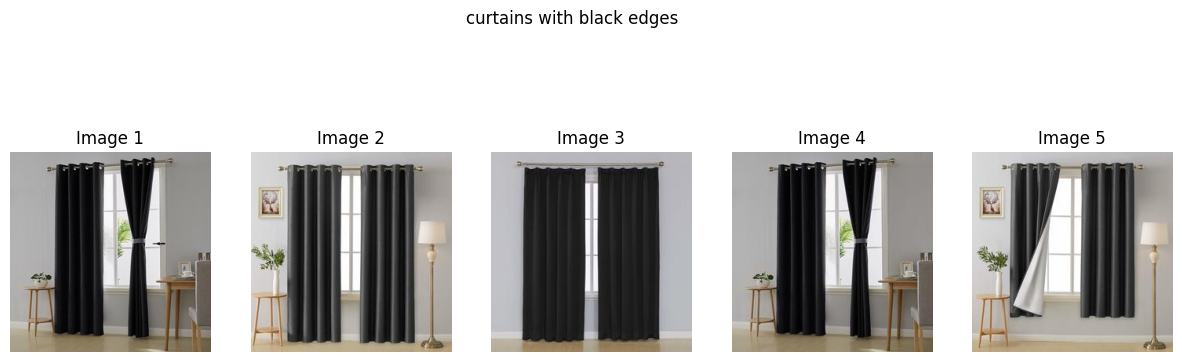

In [64]:
image_search = ImageSearch(engine, model)
image_search("cozy couch", 5)
image_search("red chair", 5)
image_search("circular, modular table", 5)
image_search("curtains with black edges", 5)

### MAX_IMAGES = 30_000

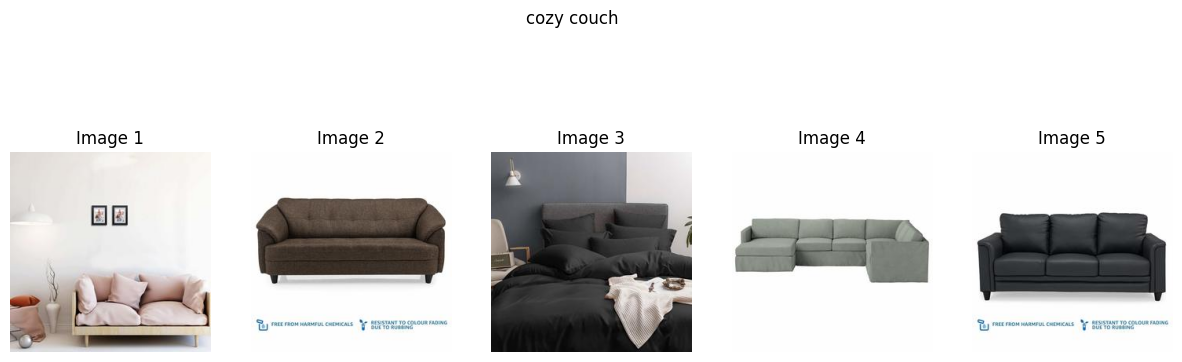

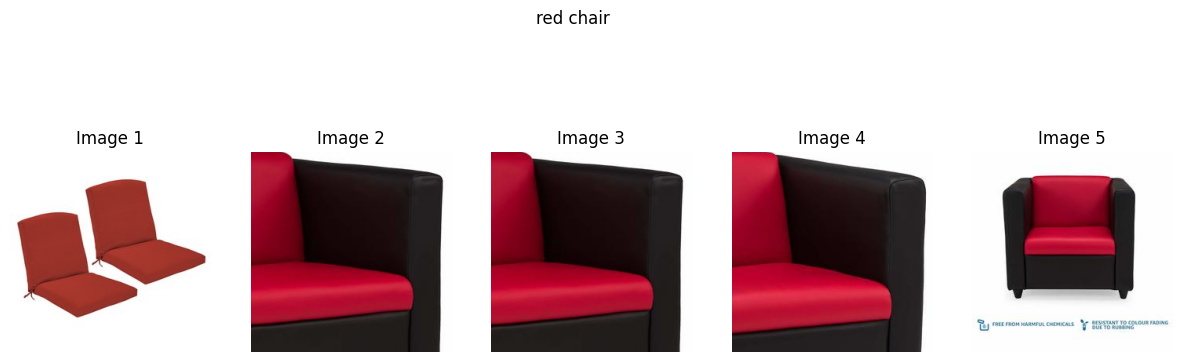

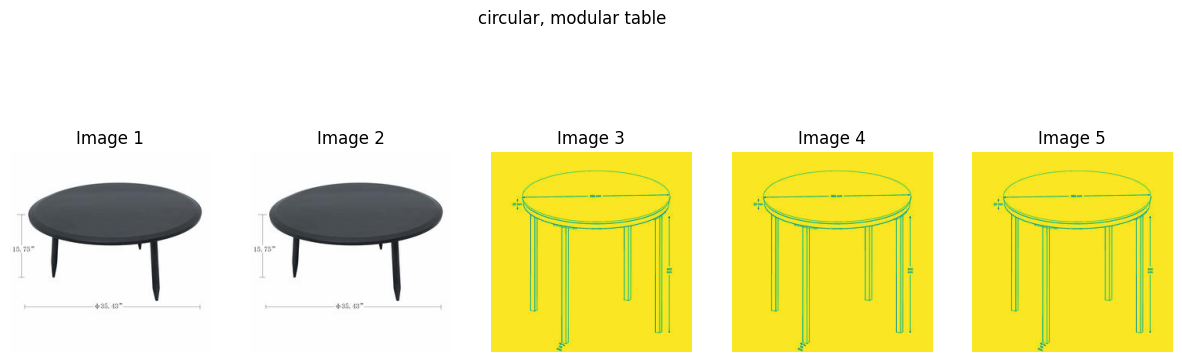

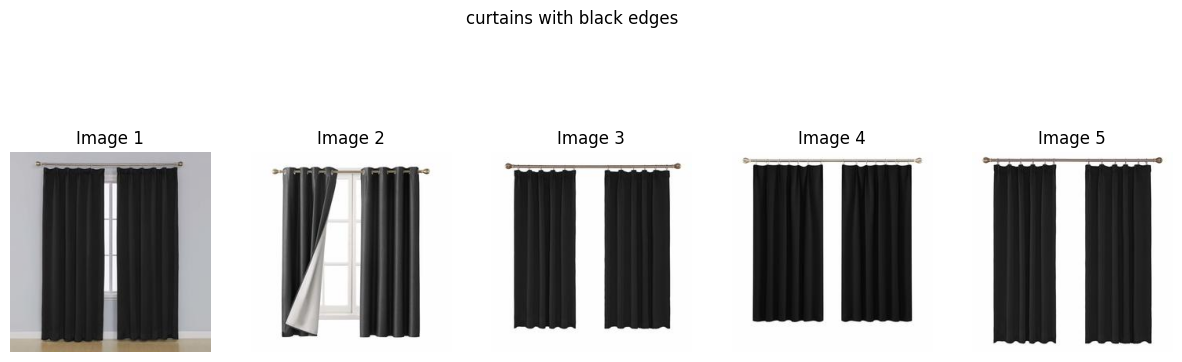

In [66]:
image_search = ImageSearch(engine, model)
image_search("cozy couch", 5)
image_search("red chair", 5)
image_search("circular, modular table", 5)
image_search("curtains with black edges", 5)

We can clearly see that more images means better results, with more details alligned with query. They're more vaired as well.